In [1]:
import json
import os
import os.path
print(os.listdir(r'C:\Users\CANARA BANK\Desktop\input'))

['lidar', 'test_data', 'test_images', 'test_lidar', 'test_maps', 'train.csv', 'train_data', 'train_images', 'train_maps']


In [2]:
#Load json files from dataset
import json
class Table:
    def __init__(self, data):
        self.data = data
        self.index = {x['token']: x for x in data}


DATA_ROOT = r'C:\Users\CANARA BANK\Desktop\input'


def load_table(name, root=os.path.join(DATA_ROOT, 'train_data')):
    with open(os.path.join(root, name), 'rb') as f:
        return Table(json.load(f))

    
scene = load_table('scene.json')
sample = load_table('sample.json')
sample_data = load_table('sample_data.json')
ego_pose = load_table('ego_pose.json')
calibrated_sensor = load_table('calibrated_sensor.json')

In [3]:
import json
import os
import os.path
import numpy as np
import pandas as pd
import random
import itertools
import copy
import math
from matplotlib import pyplot as plt
import pyquaternion
from pyquaternion import Quaternion
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from skimage.morphology import convex_hull_image

import tensorflow as tf



import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input






from tensorflow.keras.layers import Conv3D


from tensorflow.keras.layers import MaxPooling3D, UpSampling3D, Activation, BatchNormalization, PReLU
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
K.set_image_data_format('channels_first')

try:
    from tensorflow.keras.engine import merge
except ImportError:
    from tensorflow.keras.layers import concatenate    

C:\Users\CANARA BANK\Miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\CANARA BANK\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\CANARA BANK\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
In C:\Users\CANARA BANK\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CANARA BANK\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\CANARA BANK\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' 

In [4]:
# let's check the first scene
my_scene = scene.data[0]
my_scene

{'log_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100',
 'first_sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'name': 'host-a101-lidar0-1241893239199111666-1241893264098084346',
 'description': '',
 'last_sample_token': '2346756c83f6ae8c4d1adec62b4d0d31b62116d2e1819e96e9512667d15e7cec',
 'nbr_samples': 126,
 'token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}

In [5]:
#And the first sample from that scene
sample.index[my_scene['first_sample_token']]


{'next': 'c2ba18e4414ce9038ad52efab44e1a0a211ff1e6b297a632805000510756174d',
 'prev': '',
 'token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
 'timestamp': 1557858039302414.8,
 'scene_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}

In [6]:
#We'll use sample_data to fetch lidar images related to this sample. First check what is inside sample_data
sample_data.data[0]


{'is_key_frame': True,
 'prev': 'd190078ec7869ad5c9e5417371aa3b45eb1c22804a0a290ed4695042799b7470',
 'fileformat': 'bin',
 'token': 'ad87e1763749cc8562cca68e2046db128185c80c3e759919f5da448e5d9d9696',
 'timestamp': 1549920983701948.2,
 'next': '8182fb6868baf63c245a4994b7f3034a7d281d1928a7844b7b7159cff3b91a1e',
 'ego_pose_token': 'd90d278f2084ae64c98b0aa2dd8d4f83c023f1313beeaebdcefbf4529209237f',
 'sample_token': 'fd5f1c634b59e3b4e0f7a5c48c768a7d334a63221fced363a2ebac41f465830d',
 'filename': 'lidar/host-a007_lidar1_1233956183701948366.bin',
 'calibrated_sensor_token': '3b463530b5bae9698c9cc803c1731c36abd359a7296e23e81f8c0b546f60e749'}

In [7]:
#Now fetch lidar images related to the sample (note that to make it efficient you'll want to add an index like in official SDK)
lidars = []
for x in sample_data.data:
    if x['sample_token'] == my_scene['first_sample_token'] and 'lidar' in x['filename']:
        lidars.append(x)
lidars

[{'is_key_frame': True,
  'prev': '',
  'fileformat': 'bin',
  'token': 'ec9950f7b5d4ae85ae48d07786e09cebbf4ee771d054353f1e24a95700b4c4af',
  'timestamp': 1557858039302414.8,
  'next': 'b2fb6b275352ff1bc8d63cae2ec88561dddb044cae6f8e6ee7ada4ed07d79dc7',
  'ego_pose_token': '2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde',
  'sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8',
  'calibrated_sensor_token': '82130f5d48b806b62fec95989081337218fbf338ebcc95115d8afcebb305630c',
  'filename': 'lidar/host-a101_lidar1_1241893239302414726.bin'}]

In [8]:
#All lidars happen to have the same ego_pose (because they are on the same car?)
{x['ego_pose_token'] for x in lidars}

{'2d673d4bee560c77788b91e2ee24503538e74a23e7972e3e0099b92015f76dde'}

In [9]:
#Now let's load lidar's point data, we'll keep only first 3 columns (point coordinates)
lidars_data = [
    # here, sorry
    np.fromfile(os.path.join(DATA_ROOT, str(x['filename'])), dtype=np.float32)
    .reshape(-1, 5)[:, :3] for x in lidars]
lidars_data[0].shape

(107845, 3)

In [31]:
train_df = pd.read_csv(os.path.join(DATA_ROOT, 'train.csv')).set_index('Id')
train_df[:5]

,PredictionString
Id,
db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce76edd4af4d04e49341,2680.2830359778527 698.1969292852777 -18.04776...
edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e25274df2448966d929,1208.642684768659 1585.1812946970927 -23.56236...
1841b7895e7163a2c1be87e8c1740e759a910cd59157b8ac8db8c83aac0a1ae3,848.9346793681768 2587.2870557176507 -20.15995...
a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d7c3f0d6af45c4b6f2b,1994.4320280494098 1128.30164336183 -18.054752...
b909de93ba19460eeea58074ccc1ef6bb302435f37b48c6a355f4aca268a8a71,1030.3877156973385 1667.13131694941 -23.764820...


In [11]:
#Helpers to rotate bounding box points
def rotate_points(points, rotation, inverse=False):
    assert points.shape[1] == 3
    q = Quaternion(rotation)
    if inverse:
        q = q.inverse
    return np.dot(q.rotation_matrix, points.T).T
    
def apply_pose(points, cs, inverse=False):
    """ Translate (lidar) points to vehicle coordinates, given a calibrated sensor.
    """
    points = rotate_points(points, cs['rotation'])
    points = points + np.array(cs['translation'])
    return points

def inverse_apply_pose(points, cs):
    """ Reverse of apply_pose (we'll need it later).
    """
    points = points - np.array(cs['translation']) 
    points = rotate_points(points, np.array(cs['rotation']), inverse=True)
    return points

def get_annotations(token):
    annotations = np.array(train_df.loc[token].PredictionString.split()).reshape(-1, 8)
    return {
        'point': annotations[:, :3].astype(np.float32),
        'wlh': annotations[:, 3:6].astype(np.float32),
        'rotation': annotations[:, 6].astype(np.float32),
        'cls': np.array(annotations[:, 7]),
    }

In [12]:
#Helpers to rotate bounding box points
import copy

import math

def rotate(origin, point, angle):
    ox, oy, _ = origin
    px, py, pz = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return [qx, qy, pz]


def make_box_coords(center, wlh, rotation, ep):

    planar_wlh = copy.deepcopy(wlh)
    planar_wlh = planar_wlh[[1,0,2]]

    bottom_center = copy.deepcopy(center)
    bottom_center[-1] = bottom_center[-1] - planar_wlh[-1] / 2

    bottom_points = []
    bottom_points.append(bottom_center + planar_wlh * [1, 1, 0] / 2)
    bottom_points.append(bottom_center + planar_wlh * [-1, -1, 0] / 2)
    bottom_points.append(bottom_center + planar_wlh * [1, -1, 0] / 2)
    bottom_points.append(bottom_center + planar_wlh * [-1, 1, 0] / 2)
    bottom_points = np.array(bottom_points)

    rotated_bottom_points = []
    for point in bottom_points:
        rotated_bottom_points.append(rotate(bottom_center, point, rotation))

    rotated_bottom_points = np.array(rotated_bottom_points)
    rotated_top_points = rotated_bottom_points + planar_wlh * [0,0,1]

    box_points = np.concatenate([rotated_bottom_points, rotated_top_points], axis=0)

    box_points = inverse_apply_pose(box_points, ep)
    
    return box_points

In [13]:
#Helpers to get training data in raster format. To each sample we can create raster 1000x1000x100 image as 3-dimensional histogram of points. Mask is bounding boxes of cars. There is get_crop_positive function to create small crops from sample image to put it in neural network
def get_sample_data(sample_token):
    lidars = []
    for x in sample_data.data:
        if x['sample_token'] == sample_token and 'lidar' in x['filename']:
            lidars.append(x)

    lidars_data = [
        # here, sorry
        np.fromfile(os.path.join(DATA_ROOT, x['filename']), dtype=np.float32)
        .reshape(-1, 5)[:, :3] for x in lidars]


    all_points = []
    all_colors = []
    for points, lidar in zip(lidars_data, lidars):
        cs = calibrated_sensor.index[lidar['calibrated_sensor_token']]
        points = apply_pose(points, cs)
        all_points.append(points)
    all_points = np.concatenate(all_points)


    ego_pose_token, = {x['ego_pose_token'] for x in lidars}
    ep = ego_pose.index[ego_pose_token]
    annotations = get_annotations(sample_token)

    car_centers = annotations['point'][annotations['cls'] == 'car']
    car_wlhs = annotations['wlh'][annotations['cls'] == 'car']
    car_rotations = annotations['rotation'][annotations['cls'] == 'car']

    truck_centers = annotations['point'][annotations['cls'] == 'truck']
    truck_wlhs = annotations['wlh'][annotations['cls'] == 'truck']
    truck_rotations = annotations['rotation'][annotations['cls'] == 'truck']

    other_vehicle_centers = annotations['point'][annotations['cls'] == 'other_vehicle']
    other_vehicle_wlhs = annotations['wlh'][annotations['cls'] == 'other_vehicle']
    other_vehicle_rotations = annotations['rotation'][annotations['cls'] == 'other_vehicle']
    
    bus_centers = annotations['point'][annotations['cls'] == 'bus']
    bus_wlhs = annotations['wlh'][annotations['cls'] == 'bus']
    bus_rotations = annotations['rotation'][annotations['cls'] == 'bus']

    pedestrian_centers = annotations['point'][annotations['cls'] == 'pedestrian']
    pedestrian_wlhs = annotations['wlh'][annotations['cls'] == 'pedestrian']
    pedestrian_rotations = annotations['rotation'][annotations['cls'] == 'pedestrian']

    bicycle_centers = annotations['point'][annotations['cls'] == 'bicycle']
    bicycle_wlhs = annotations['wlh'][annotations['cls'] == 'bicycle']
    bicycle_rotations = annotations['rotation'][annotations['cls'] == 'bicycle']


    # Car
    car_boxes = []
    for k in range(len(car_centers)):
        center = car_centers[k]
        wlh = car_wlhs[k]
        rotation = car_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        car_boxes.append(box_coords)

    car_boxes = np.array(car_boxes)    
    car_centers = inverse_apply_pose(car_centers, ep)
    
    # Truck
    truck_boxes = []
    for k in range(len(truck_centers)):
        center = truck_centers[k]
        wlh = truck_wlhs[k]
        rotation = truck_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        truck_boxes.append(box_coords)

    truck_boxes = np.array(truck_boxes)    
    truck_centers = inverse_apply_pose(truck_centers, ep)
    
    # Other vehicle
    other_vehicle_boxes = []
    for k in range(len(other_vehicle_centers)):
        center = other_vehicle_centers[k]
        wlh = other_vehicle_wlhs[k]
        rotation = other_vehicle_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        other_vehicle_boxes.append(box_coords)

    other_vehicle_boxes = np.array(other_vehicle_boxes)    
    other_vehicle_centers = inverse_apply_pose(other_vehicle_centers, ep)
    
    # Bus
    bus_boxes = []
    for k in range(len(bus_centers)):
        center = bus_centers[k]
        wlh = bus_wlhs[k]
        rotation = bus_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        bus_boxes.append(box_coords)

    bus_boxes = np.array(bus_boxes)    
    bus_centers = inverse_apply_pose(bus_centers, ep)
    
    # Pedestrian
    pedestrian_boxes = []
    for k in range(len(pedestrian_centers)):
        center = pedestrian_centers[k]
        wlh = pedestrian_wlhs[k]
        rotation = pedestrian_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        pedestrian_boxes.append(box_coords)

    pedestrian_boxes = np.array(pedestrian_boxes)    
    pedestrian_centers = inverse_apply_pose(pedestrian_centers, ep)
    
    # Bicycle
    bicycle_boxes = []
    for k in range(len(bicycle_centers)):
        center = bicycle_centers[k]
        wlh = bicycle_wlhs[k]
        rotation = bicycle_rotations[k]

        box_coords = make_box_coords(center, wlh, rotation, ep)
        bicycle_boxes.append(box_coords)

    bicycle_boxes = np.array(bicycle_boxes)    
    bicycle_centers = inverse_apply_pose(bicycle_centers, ep)
    
    return all_points, \
        car_boxes, car_centers, \
        truck_boxes, truck_centers, \
        other_vehicle_boxes, other_vehicle_centers, \
        bus_boxes, bus_centers, \
        pedestrian_boxes, pedestrian_centers, \
        bicycle_boxes, bicycle_centers


def get_sample_raster(all_points, all_boxes): 
    x_bounds = np.linspace(-100, 100, 1001)
    y_bounds = np.linspace(-100, 100, 1001)
    z_bounds = np.linspace(-10, 10, 101)

    sample_hist = np.histogramdd(all_points[:], [x_bounds, y_bounds, z_bounds])[0]
    sample_mask = np.zeros((len(x_bounds)-1, len(y_bounds)-1, len(z_bounds)-1))



    for box in all_boxes:
        x_min, y_min, z_min = box.min(axis=0)
        x_max, y_max, z_max = box.max(axis=0)

        x_box_bound_cnt = int(1001 / 200 * (x_max - x_min))
        y_box_bound_cnt = int(1001 / 200 * (y_max - y_min))
        z_box_bound_cnt = int(101 / 20 * (z_max - z_min))

        box_hist = np.histogramdd(box, [np.linspace(x_min, x_max, x_box_bound_cnt),
                                        np.linspace(y_min, y_max, y_box_bound_cnt),
                                        np.linspace(z_min, z_max, z_box_bound_cnt)])[0]


        try:
            box_mask = convex_hull_image(box_hist)
        except:
            continue


        x_start_idx = np.where(x_bounds > x_min)[0][0]
        y_start_idx = np.where(y_bounds > y_min)[0][0]
        z_start_idx = np.where(z_bounds > z_min)[0][0]


        x_cnt = min(sample_mask.shape[0] - x_start_idx - 1, x_box_bound_cnt - 1)
        y_cnt = min(sample_mask.shape[1] - y_start_idx - 1, y_box_bound_cnt - 1)
        z_cnt = min(sample_mask.shape[2] - z_start_idx - 1, z_box_bound_cnt - 1)

        sample_mask[x_start_idx:x_start_idx+x_cnt,
                   y_start_idx:y_start_idx+y_cnt,
                   z_start_idx:z_start_idx+z_cnt] = sample_mask[x_start_idx:x_start_idx+x_cnt,
                                                                           y_start_idx:y_start_idx+y_cnt,
                                                                           z_start_idx:z_start_idx+z_cnt] + box_mask[:x_cnt, :y_cnt, :z_cnt]

    return sample_hist, sample_mask, (x_bounds, y_bounds, z_bounds)


def get_crop_positive(sample_hist, sample_mask, bounds, centers, crop_size=(64, 64, 32)):
    
    half_x_size = crop_size[0] // 2
    half_y_size = crop_size[1] // 2
    half_z_size = crop_size[2] // 2
    
    (x_bounds, y_bounds, z_bounds) = bounds
    if len(centers) > 0:
        idx = np.random.choice(range(len(centers)))
        x_center, y_center, z_center = centers[idx]
    else:
        x_center, y_center = np.random.randint(-30, 30, 2)
        z_center = np.random.randint(-10, 10)

    x_center, y_center, z_center = [x_center, y_center, z_center] + np.random.randint(-3, 3, 3)

    x_center = min(x_center, 100 - np.abs(x_bounds[-1] - x_bounds[-2]) * half_x_size - 1)
    x_center = max(x_center, -100 + np.abs(x_bounds[-1] - x_bounds[-2]) * half_x_size + 1)

    y_center = min(y_center, 100 - np.abs(y_bounds[-1] - y_bounds[-2]) * half_y_size - 1)
    y_center = max(y_center, -100 + np.abs(y_bounds[-1] - y_bounds[-2]) * half_y_size + 1)

    z_center = min(z_center, 10 - np.abs(z_bounds[-1] - z_bounds[-2]) * half_z_size - 1)
    z_center = max(z_center, -10 + np.abs(z_bounds[-1] - z_bounds[-2]) * half_z_size + 1)




    x_center_idx = np.where(x_bounds > x_center)[0][0]
    y_center_idx = np.where(y_bounds > y_center)[0][0]
    z_center_idx = np.where(z_bounds > z_center)[0][0]

        
    crop_hist = sample_hist[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    
    crop_mask = sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]

    return crop_hist, crop_mask > 0



def get_crop_over_all_classes(sample_hist, bounds, \
                              car_sample_mask, truck_sample_mask, \
                              other_vehicle_sample_mask, bus_sample_mask, \
                              pedestrian_sample_mask, bicycle_sample_mask, \
                              car_centers, truck_centers, \
                              other_vehicle_centers, bus_centers, \
                              pedestrian_centers, bicycle_centers, \
                              crop_size=(64, 64, 32)):
    
    half_x_size = crop_size[0] // 2
    half_y_size = crop_size[1] // 2
    half_z_size = crop_size[2] // 2
    
    (x_bounds, y_bounds, z_bounds) = bounds
    
    centers = np.concatenate((car_centers, truck_centers, other_vehicle_centers, bus_centers, pedestrian_centers, bicycle_centers), axis=0)
    if len(centers) > 0:
        idx = np.random.choice(range(len(centers)))
        x_center, y_center, z_center = centers[idx]
    else:
        x_center, y_center = np.random.randint(-30, 30, 2)
        z_center = np.random.randint(-10, 10)


    x_center, y_center, z_center = [x_center, y_center, z_center] + np.random.randint(-3, 3, 3)

    x_center = min(x_center, 100 - np.abs(x_bounds[-1] - x_bounds[-2]) * half_x_size - 1)
    x_center = max(x_center, -100 + np.abs(x_bounds[-1] - x_bounds[-2]) * half_x_size + 1)

    y_center = min(y_center, 100 - np.abs(y_bounds[-1] - y_bounds[-2]) * half_y_size - 1)
    y_center = max(y_center, -100 + np.abs(y_bounds[-1] - y_bounds[-2]) * half_y_size + 1)

    z_center = min(z_center, 10 - np.abs(z_bounds[-1] - z_bounds[-2]) * half_z_size - 1)
    z_center = max(z_center, -10 + np.abs(z_bounds[-1] - z_bounds[-2]) * half_z_size + 1)




    x_center_idx = np.where(x_bounds > x_center)[0][0]
    y_center_idx = np.where(y_bounds > y_center)[0][0]
    z_center_idx = np.where(z_bounds > z_center)[0][0]

        
    crop_hist = sample_hist[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    
    car_crop_mask = car_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    truck_crop_mask = truck_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    other_vehicle_crop_mask = other_vehicle_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    bus_crop_mask = bus_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    pedestrian_crop_mask = pedestrian_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]
    bicycle_crop_mask = bicycle_sample_mask[x_center_idx-half_x_size:x_center_idx+half_x_size,
                            y_center_idx-half_y_size:y_center_idx+half_y_size,
                            z_center_idx-half_z_size:z_center_idx+half_z_size]

    crop_mask = np.array((car_crop_mask, truck_crop_mask, other_vehicle_crop_mask, bus_crop_mask, pedestrian_crop_mask, bicycle_crop_mask))
    

    return crop_hist, crop_mask > 0

In [14]:
#Data example
sample_token = train_df.reset_index()['Id'].values[71]

all_points, car_boxes, car_centers, \
truck_boxes, truck_centers, \
other_vehicle_boxes, other_vehicle_centers, \
bus_boxes, bus_centers, \
pedestrian_boxes, pedestrian_centers, \
bicycle_boxes, bicycle_centers = get_sample_data(sample_token)

In [15]:
# sample_hist, sample_mask, bounds = get_sample_raster(all_points, all_boxes)

car_sample_hist, car_sample_mask, car_bounds = get_sample_raster(all_points, car_boxes)
truck_sample_hist, truck_sample_mask, truck_bounds = get_sample_raster(all_points, truck_boxes)
other_vehicle_sample_hist, other_vehicle_sample_mask, other_vehicle_bounds = get_sample_raster(all_points, other_vehicle_boxes)
bus_sample_hist, bus_sample_mask, bus_bounds = get_sample_raster(all_points, bus_boxes)
pedestrian_sample_hist, pedestrian_sample_mask, pedestrian_bounds = get_sample_raster(all_points, pedestrian_boxes)
bicycle_sample_hist, bicycle_sample_mask, bicycle_bounds = get_sample_raster(all_points, bicycle_boxes)

In [16]:
crop_hist, crop_mask = get_crop_over_all_classes(
    car_sample_hist, car_bounds, \
    car_sample_mask, truck_sample_mask, \
    other_vehicle_sample_mask, bus_sample_mask, \
    pedestrian_sample_mask, bicycle_sample_mask, \
    car_centers, truck_centers, \
    other_vehicle_centers, bus_centers, \
    pedestrian_centers, bicycle_centers, \
    crop_size=(128,128,64))

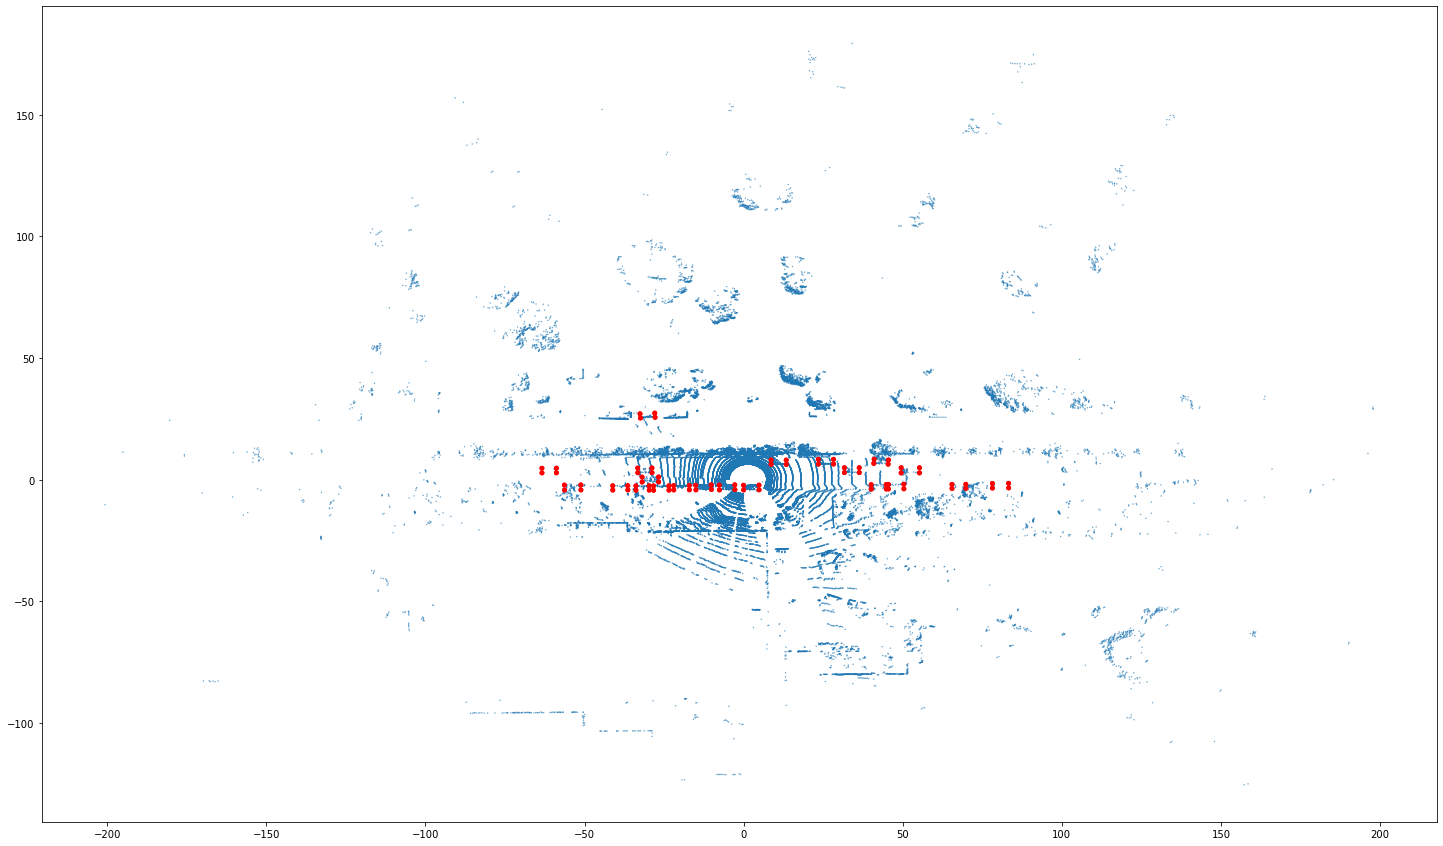

In [17]:
#Source point cloud for full sample
boxes_coords = np.concatenate(car_boxes, axis=0)


plt.figure(figsize=(25,15))
plt.scatter(all_points[:, 0], all_points[:, 1],s=[0.1]*len(all_points))
plt.scatter(boxes_coords[:, 0], boxes_coords[:, 1],s=[15]*len(boxes_coords),color='r')

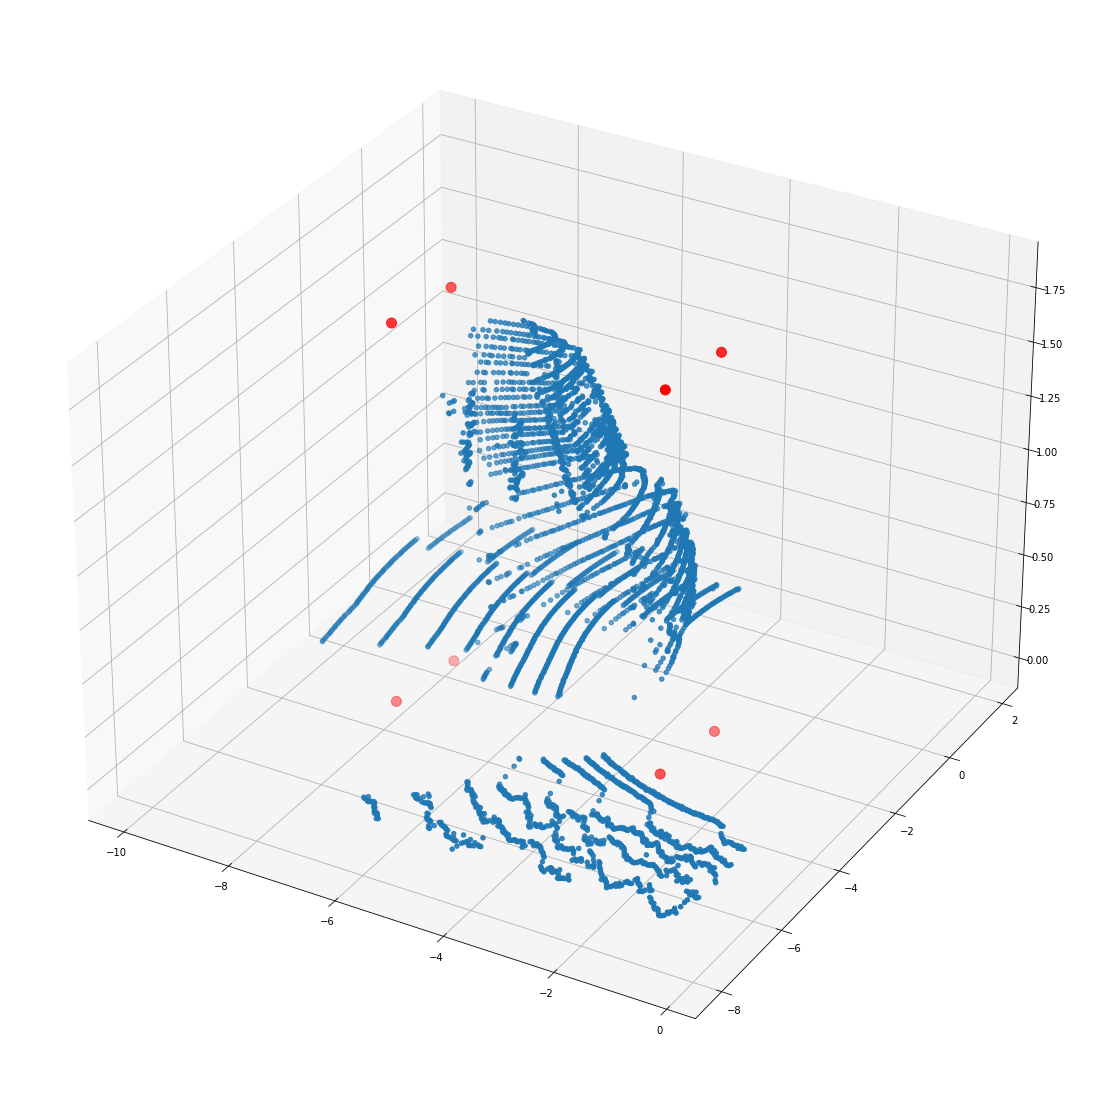

In [18]:
#Source point cloud for small region with car
ann_idx = 20

center_point = car_centers[ann_idx]
x_min = center_point[0] - 5
x_max = center_point[0] + 5
y_min = center_point[1] - 5
y_max = center_point[1] + 5
z_min= center_point[2] - 5
z_max = center_point[2] + 5


area_mask = (all_points[:, 0] > x_min) * (all_points[:, 0] < x_max) * (all_points[:, 1] > y_min) * (all_points[:, 1] < y_max) * (all_points[:, 2] > z_min) * (all_points[:, 2] < z_max)
area_mask = np.where(area_mask)[0]


fig = pyplot.figure(figsize=(25,15))
ax = Axes3D(fig)
ax.scatter(all_points[area_mask, 0], all_points[area_mask, 1], all_points[area_mask, 2])


ax.scatter(car_boxes[ann_idx][:, 0], car_boxes[ann_idx][:, 1], car_boxes[ann_idx][:, 2], color='r', s=[100])



pyplot.show()


In [19]:
#Define 3D U-Net model
def unet_model_3d(input_shape, pool_size=(2, 2, 2), n_labels=1, initial_learning_rate=0.00001, deconvolution=False,
                  depth=4, n_base_filters=32,
                  batch_normalization=False, activation_name="sigmoid"):
    
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer, n_filters=n_base_filters*(2**layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1, n_filters=n_base_filters*(2**layer_depth)*2,
                                          batch_normalization=batch_normalization)
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth-2, -1, -1):
        up_convolution = get_up_convolution(pool_size=pool_size, deconvolution=deconvolution,
                                            n_filters=current_layer.shape[1])(current_layer)
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        current_layer = create_convolution_block(n_filters=levels[layer_depth][1].shape[1],
                                                 input_layer=concat, batch_normalization=batch_normalization)
        current_layer = create_convolution_block(n_filters=levels[layer_depth][1].shape[1],
                                                 input_layer=current_layer,
                                                 batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels,(1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    return model


def create_convolution_block(input_layer, n_filters, batch_normalization=False, kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1), instance_normalization=False):

    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(input_layer)
    if batch_normalization:
            
        
        
        
        
        layer = BatchNormalization(axis=1)(layer)
    elif instance_normalization:
        from keras_contrib.layers.normalization import InstanceNormalization

        layer = InstanceNormalization(axis=1)(layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)


def compute_level_output_shape(n_filters, depth, pool_size, image_shape):
    output_image_shape = np.asarray(np.divide(image_shape, np.power(pool_size, depth)), dtype=np.int32).tolist()
    return tuple([None, n_filters] + output_image_shape)


def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2), strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Deconvolution3D(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)

In [20]:
#Define generator
tokens = train_df.reset_index()['Id'].values

def generator(tokens, crop_size, batch_size):
    while True:
        sample_token = np.random.choice(tokens)
        all_points, car_boxes, car_centers, truck_boxes, truck_centers, other_vehicle_boxes, other_vehicle_centers, bus_boxes, bus_centers, pedestrian_boxes, pedestrian_centers, bicycle_boxes, bicycle_centers = get_sample_data(sample_token)


        # All generated sample_hists of all classes are the same, so we just pick one
        sample_hist, car_sample_mask, bounds = get_sample_raster(all_points, car_boxes)
        _, truck_sample_mask, _ = get_sample_raster(all_points, truck_boxes)
        _, other_vehicle_sample_mask, _ = get_sample_raster(all_points, other_vehicle_boxes)
        _, bus_sample_mask, _ = get_sample_raster(all_points, bus_boxes)
        _, pedestrian_sample_mask, _ = get_sample_raster(all_points, pedestrian_boxes)
        _, bicycle_sample_mask, _ = get_sample_raster(all_points, bicycle_boxes)
        
        x_batch = []
        y_batch = []
        for _ in range(batch_size):
            crop_hist, crop_mask = get_crop_over_all_classes(
                sample_hist, bounds, \
                car_sample_mask, truck_sample_mask, \
                other_vehicle_sample_mask, bus_sample_mask, \
                pedestrian_sample_mask, bicycle_sample_mask, \
                car_centers, truck_centers, \
                other_vehicle_centers, bus_centers, \
                pedestrian_centers, bicycle_centers, \
                crop_size=crop_size)

            x_batch.append(crop_hist)
            y_batch.append(crop_mask)
        
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)
        
        x_batch = np.expand_dims(x_batch, axis=1)
        
        yield x_batch , y_batch

In [21]:
#Define metrics
def jaccard_coef(y_true, y_pred):
    smooth = 1e-12
    intersection = K.sum(y_true * y_pred, axis=[-1, -2, -3])
    sum_ = K.sum(y_true + y_pred, axis=[-1, -2, -3])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    smooth = 1e-12
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[-1, -2, -3])
    sum_ = K.sum(y_true + y_pred_pos, axis=[-1, -2, -3])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [22]:
#Define loss function
def weighted_binary_crossentropy(alpha=0.75):
    def weighted_binary_crossentropy_fixed(y_true, y_pred):
        binary_crossentropy = K.binary_crossentropy(y_true, y_pred)
        weight_vec = alpha * y_true + (1 - alpha) * (1 - y_true)
        
        return K.mean(binary_crossentropy * weight_vec)
        
    return weighted_binary_crossentropy_fixed


def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.

      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)

      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.

    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)

    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f=tf.cast(y_true_f,tf.float32)
    y_pred_f=tf.cast(y_pred_f,tf.float32)
    intersection = tf.cast(y_true_f,tf.float32) * tf.cast(y_pred_f,tf.float32)
    intersection =tf.cast(intersection,tf.float32)
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [23]:
#Configure parameters
batch_size = 16
lr = 1e-5
epochs = 10

In [24]:
#Create train and validation generators
train_loader = generator(tokens[:15000], (64,64,32), batch_size)
val_loader = generator(tokens[15000:], (64,64,32), batch_size)

for x_batch, y_batch in train_loader:
    break
    
print(x_batch.shape)
print(y_batch.shape)

(16, 1, 64, 64, 32)
(16, 6, 64, 64, 32)


In [25]:
#Create callbacks
tensorboard_callback = TensorBoard(
    log_dir='./',
    histogram_freq=0,
    batch_size=batch_size,
    write_graph=False,
    write_grads=False,
    write_images=False,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None
)

reduce_lr_on_plateau_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

model_checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    period=1
)

callbacks=[
    tensorboard_callback,
    reduce_lr_on_plateau_callback,
    model_checkpoint
]

In [26]:
#Training the model 
model = unet_model_3d((1, 64,64,32), n_labels=6)
adam = tensorflow.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss=bce_dice_loss,
        optimizer=adam,
        metrics=[dice_coef, jaccard_coef, jaccard_coef_int])

In [27]:
#This training from scratch works on a high end GPU which would take up a lot of memory and time
#model.fit(x_batch,y_batch,batch_size=16,steps_per_epoch=100,
 #                    epochs=epochs,verbose=1,
  #                   callbacks=callbacks,
   #                  validation_data=val_loader,
    #                 validation_steps=50,
     #                class_weight=None,
      #               max_queue_size=10,
       #              use_multiprocessing=False,
        #             shuffle=True,
         #            initial_epoch=0)

In [28]:
#Load pre-trained model weights(as training the UNET model from scratch as lidars may take upto 5-6 hours on an efficient GPU)

!wget "https://drive.google.com/uc?id=11BXmZn3lGMKE-ukHnKiRvb6ZyVV9XZ1g&export=download" -O pretrained_weights.h5

--2021-05-25 16:35:00--  https://drive.google.com/uc?id=11BXmZn3lGMKE-ukHnKiRvb6ZyVV9XZ1g&export=download
Resolving drive.google.com (drive.google.com)... 2404:6800:4007:829::200e, 216.58.196.174
Connecting to drive.google.com (drive.google.com)|2404:6800:4007:829::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o9c05af6cei8tobso09oq43i473orek3/1621940700000/14899537481691494229/*/11BXmZn3lGMKE-ukHnKiRvb6ZyVV9XZ1g?e=download [following]
--2021-05-25 16:35:02--  https://doc-0c-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o9c05af6cei8tobso09oq43i473orek3/1621940700000/14899537481691494229/*/11BXmZn3lGMKE-ukHnKiRvb6ZyVV9XZ1g?e=download
Resolving doc-0c-ak-docs.googleusercontent.com (doc-0c-ak-docs.googleusercontent.com)... 2404:6800:4007:825::2001, 142.250.193.161
Connecting to doc-0c-ak-docs.googleusercontent.com (doc-

  6350K .......... .......... .......... .......... .......... 6.80M
  6400K .......... .......... .......... .......... .......... 6.10M
  6450K .......... .......... .......... .......... .......... 9.82M
  6500K .......... .......... .......... .......... .......... 13.5M
  6550K .......... .......... .......... .......... .......... 16.4M
  6600K .......... .......... .......... .......... .......... 16.0M
  6650K .......... .......... .......... .......... .......... 2.75M
  6700K .......... .......... .......... .......... .......... 17.1M
  6750K .......... .......... .......... .......... .......... 18.8M
  6800K .......... .......... .......... .......... .......... 18.2M
  6850K .......... .......... .......... .......... .......... 19.0M
  6900K .......... .......... .......... .......... .......... 19.6M
  6950K .......... .......... .......... .......... .......... 18.8M
  7000K .......... .......... .......... .......... .......... 17.0M
  7050K .......... .......... ....

In [29]:
#Here we are loading the pretrained weights to our model
model.load_weights('pretrained_weights.h5')
#This prediction also needs a high end GPU for large size lidar files
#val_loader = generator(tokens[15000:], (64,64,32), 16)
#for x_batch, y_batch in val_loader:
#   break 
#pred = model.predict(x_batch)


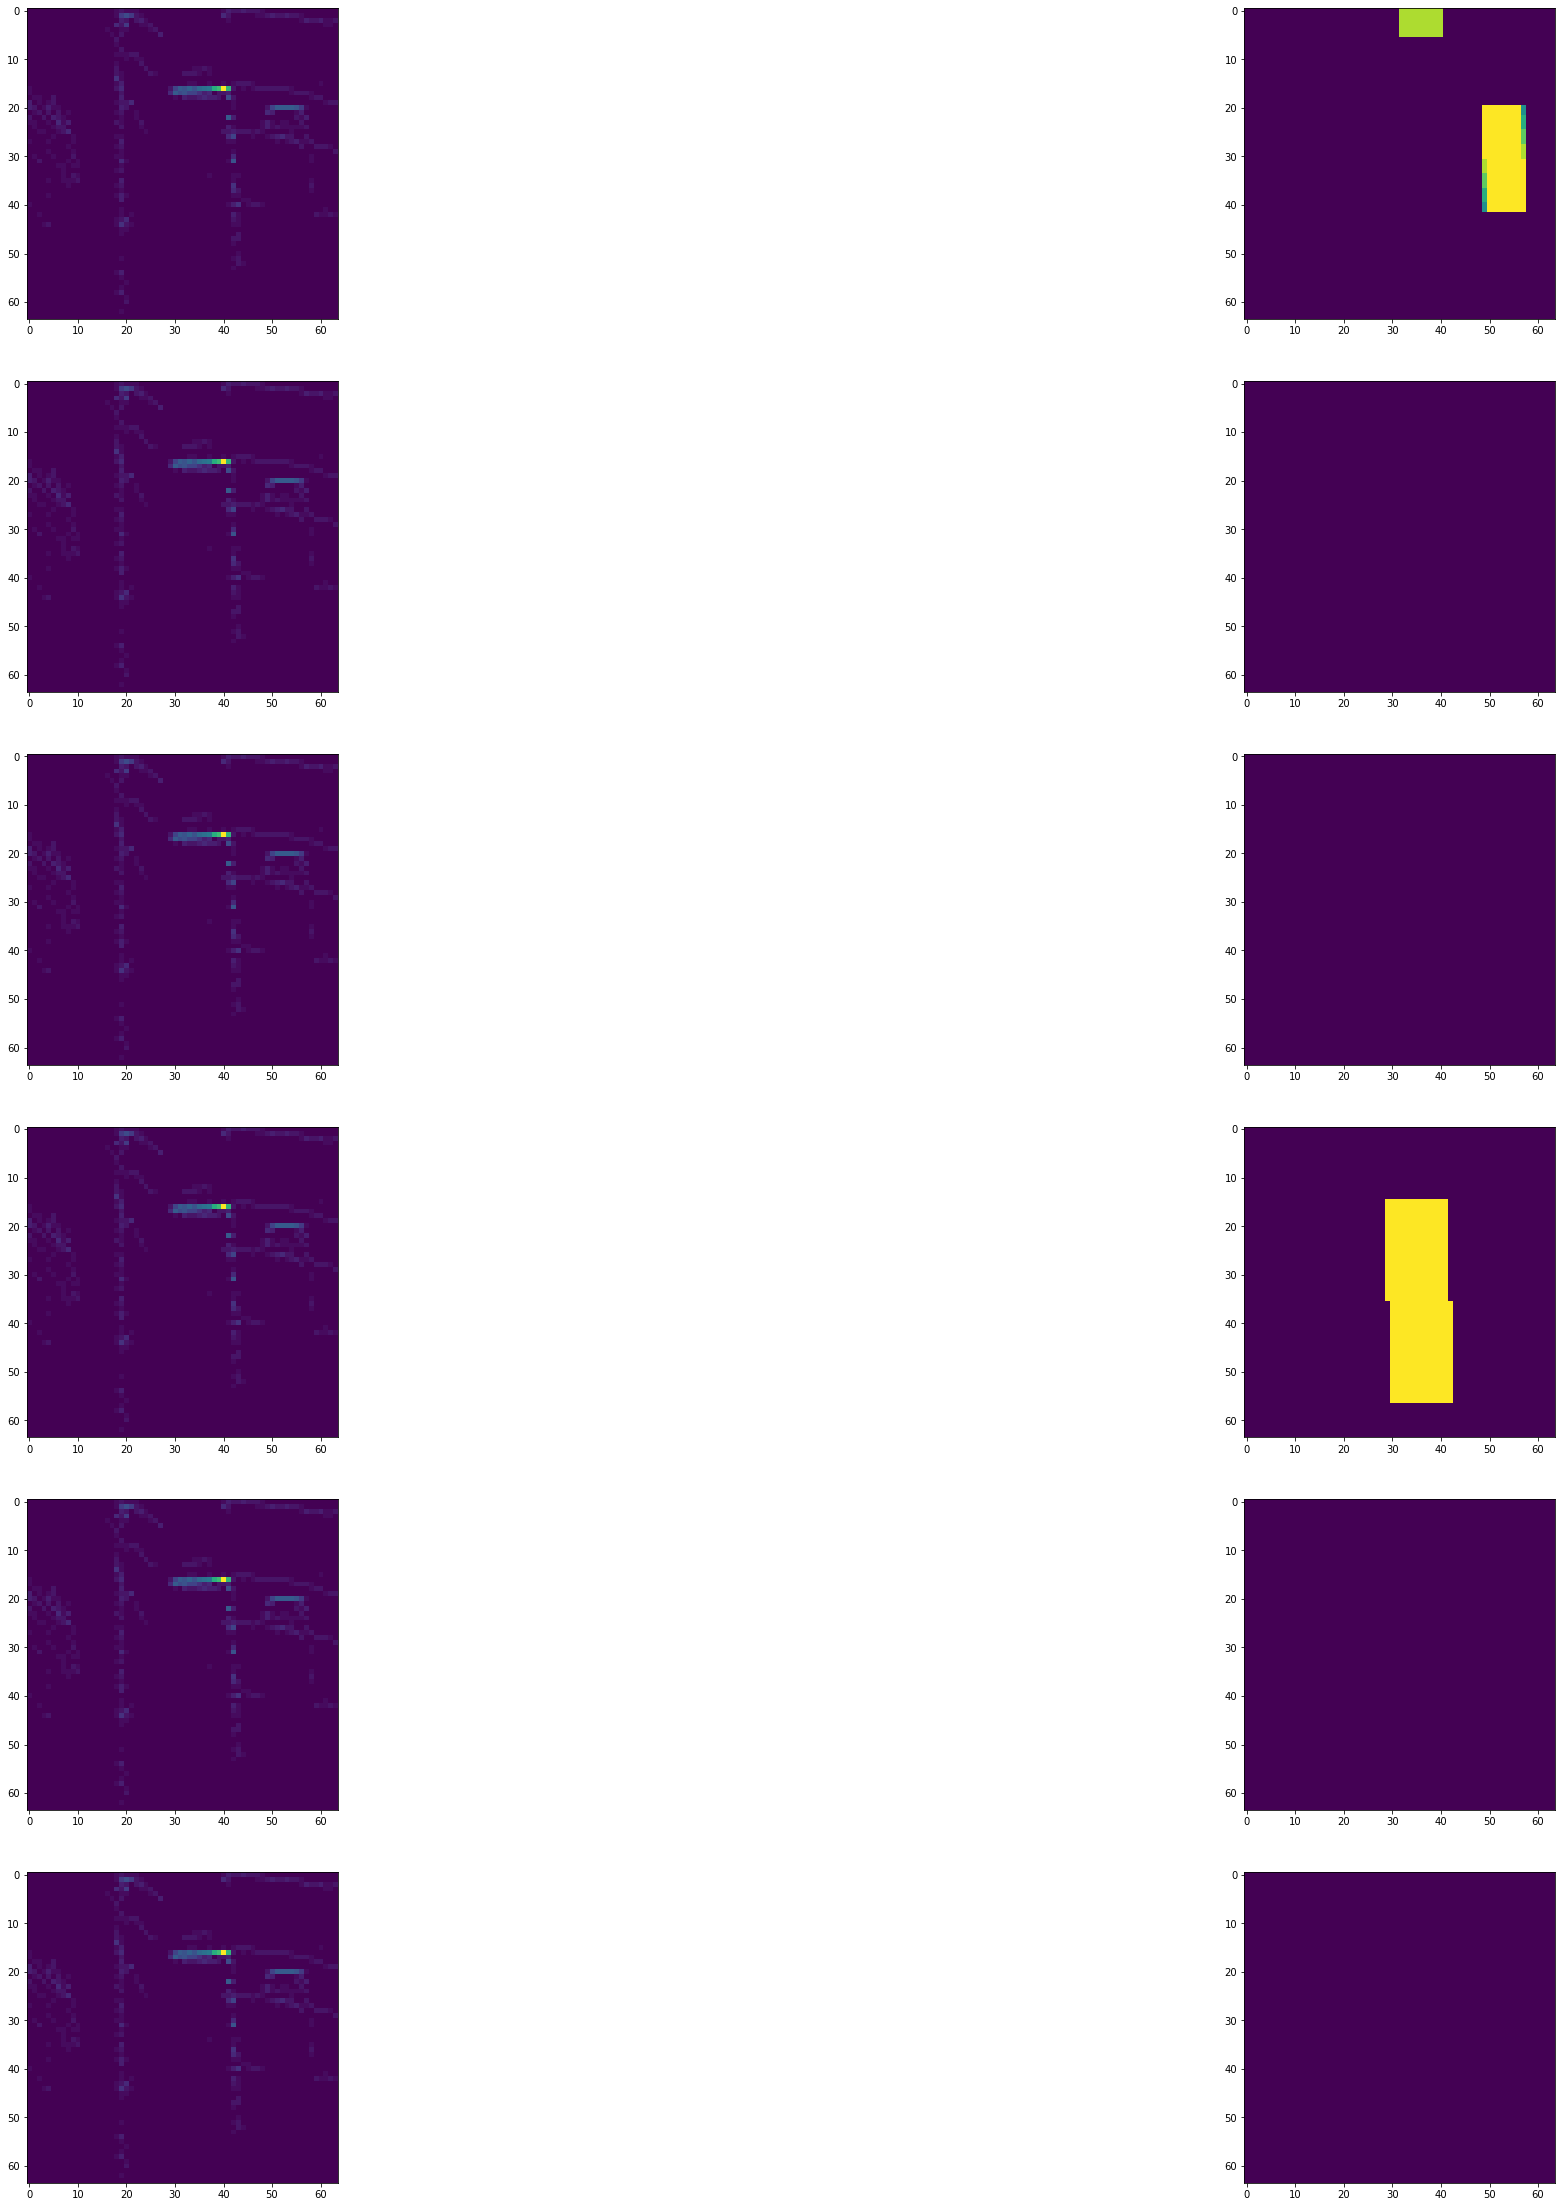

In [30]:
#Sample Output of predictions using the lidars in different XY-plane and Y-Z planes projections
idx = 0
fig, predictions = plt.subplots(6, 2, figsize=(40, 40))
for i in range(6):
    predictions[i][0].imshow(x_batch[idx].sum(axis=(0, -1)))
    predictions[i][1].imshow(np.expand_dims(y_batch[idx][i], axis=0).sum(axis=(0, -1)))
    
plt.show()